# Testing final graph

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd() + "./../")))

import json
import operator
from typing import Annotated

from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from typing_extensions import TypedDict

from src.agents.tools import modifiers, special_hits
from src.prompts.prompts import (
    FIGHT_EVOLUTION_PROMPT,
    FIGHTERS_MOVES_PROMPT,
    NARRATOR_PROMPT,
    ORCHESTRATOR_PROMPT,
    SCENARIO_PROMPT,
    UPDATER_PROMPT,
)
from src.utils.databases import (
    add_exp_to_winner,
    add_fighter,
    create_tables,
    get_fighter_info,
    update_leaderboard_loser,
    update_leaderboard_winner,
    update_scores,
)
from src.utils.utils import tprint

In [2]:
class FightState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    fight_evolution: Annotated[list[AnyMessage], operator.add]

    round: int = 1
    modifiers: str

    winner: str
    loser: str

    # Fighter 1
    fighter1_name: str
    fighter1_description: str
    fighter1_health: int
    fighter1_strenght: int
    fighter1_agility: int
    fighter1_intelligence: int
    fighter1_armor: int
    fighter1_tiredness: int = 0
    fighter1_move: str

    # Fighter 2
    fighter2_name: str
    fighter2_description: str
    fighter2_health: int
    fighter2_strenght: int
    fighter2_agility: int
    fighter2_intelligence: int
    fighter2_armor: int
    fighter2_tiredness: int = 0
    fighter2_move: str

In [3]:
class AgenticFight:
    MAX_ROUNDS = 3

    def __init__(self, model, tools, checkpointer=None):
        self.model = model

        # Graph
        ########
        builder = StateGraph(FightState)

        # Set nodes
        builder.add_node("prepare_fight", self.prepare_fight)
        builder.add_node("characters_moves", self.characters_moves)
        builder.add_node("orchestrator", self.orchestrator)
        builder.add_node("tools", ToolNode(tools))
        builder.add_node("narrator", self.narrator)
        builder.add_node("updater", self.updater)

        # Logic
        builder.add_edge(START, "prepare_fight")
        builder.add_edge("prepare_fight", "characters_moves")
        builder.add_edge("characters_moves", "orchestrator")
        builder.add_conditional_edges(
            "orchestrator",
            self.route_tools,
            {"tools": "tools", "narrator": "narrator"},
        )
        builder.add_edge("tools", "orchestrator")
        builder.add_conditional_edges(
            "narrator",
            self.fight_continues,
            {"characters_moves": "characters_moves", "updater": "updater"},
        )
        builder.add_edge("updater", END)

        # Compile graph
        self.graph = builder.compile(
            interrupt_before=["characters_moves"], checkpointer=checkpointer
        )

    # Nodes
    ########
    @staticmethod
    def prepare_fight(state: FightState):
        # Create database and tables, if they do not exist
        create_tables()
        tprint("Tables created!")

        # Get fighters info and try to update the fighters table
        fighters_info = json.load(open("./src/prompts/fighters.json", "r"))
        add_fighter(fighters_info["fighter1"])
        add_fighter(fighters_info["fighter2"])
        tprint("Fighters added!")

        # Get latest fighter info
        fighter1_info = get_fighter_info(fighters_info["fighter1"]["name"])
        fighter2_info = get_fighter_info(fighters_info["fighter2"]["name"])
        state.update(
            {
                "fighter1_name": fighter1_info["name"],
                "fighter1_description": fighter1_info["description"],
                "fighter1_health": fighter1_info["health"],
                "fighter1_strenght": fighter1_info["strength"],
                "fighter1_agility": fighter1_info["agility"],
                "fighter1_intelligence": fighter1_info["intelligence"],
                "fighter1_armor": fighter1_info["armor"],
                "fighter1_tiredness": fighter1_info["tiredness"],
                "fighter2_name": fighter2_info["name"],
                "fighter2_description": fighter2_info["description"],
                "fighter2_health": fighter2_info["health"],
                "fighter2_strenght": fighter2_info["strength"],
                "fighter2_agility": fighter2_info["agility"],
                "fighter2_intelligence": fighter2_info["intelligence"],
                "fighter2_armor": fighter2_info["armor"],
                "fighter2_tiredness": fighter2_info["tiredness"],
            }
        )
        tprint("Fighters info retrieved and updated!")

        # Add prompts
        state["fight_evolution"] = [
            FIGHT_EVOLUTION_PROMPT.format(
                scenario=SCENARIO_PROMPT,
                fighter1_name=state["fighter1_name"],
                fighter1_description=state["fighter1_description"],
                fighter2_name=state["fighter2_name"],
                fighter2_description=state["fighter2_description"],
            )
        ]
        tprint("Prompts assigned!")

    @staticmethod
    def characters_moves(state: FightState):
        # Human feedback node
        tprint(
            FIGHTERS_MOVES_PROMPT.format(
                fighter1_name=state["fighter1_name"],
                fighter1_move=state["fighter1_move"],
                fighter2_name=state["fighter2_name"],
                fighter2_move=state["fighter2_move"],
            ),
            10,
        )

        return {
            "messages": HumanMessage(
                content=FIGHTERS_MOVES_PROMPT.format(
                    fighter1_name=state["fighter1_name"],
                    fighter1_move=state["fighter1_move"],
                    fighter2_name=state["fighter2_name"],
                    fighter2_move=state["fighter2_move"],
                )
            )
        }

    def orchestrator(self, state: FightState):
        modifiers = ORCHESTRATOR_PROMPT.format(
            fight_evolution=state["fight_evolution"],
            fighters_moves=state["messages"][-1].content,
        )
        state["modifiers"] = self.model.invoke([SystemMessage(content=modifiers)])

        tprint(state["modifiers"])

        return {"messages": [SystemMessage(state["modifiers"])]}

    def narrator(self, state: FightState):
        context = NARRATOR_PROMPT.format(
            fight_evolution=state["fight_evolution"],
            fighter1_name=state["fighter1_name"],
            fighter1_move=state["fighter1_move"],
            fighter2_name=state["fighter2_name"],
            fighter2_move=state["fighter2_move"],
            modifiers=state["messages"][-1].content,
            fighter1_health=state["fighter1_health"],
            fighter1_strength=state["fighter1_strenght"],
            fighter1_agility=state["fighter1_agility"],
            fighter1_intelligence=state["fighter1_intelligence"],
            fighter1_armor=state["fighter1_armor"],
            fighter1_tiredness=state["fighter1_tiredness"],
            fighter2_health=state["fighter2_health"],
            fighter2_strength=state["fighter2_strenght"],
            fighter2_agility=state["fighter2_agility"],
            fighter2_intelligence=state["fighter2_intelligence"],
            fighter2_armor=state["fighter2_armor"],
            fighter2_tiredness=state["fighter2_tiredness"],
        )

        result = self.model.with_structured_output(RoundResult).invoke(context)
        state["fighter1_health"] = result["health_remaining_fighter1"]
        state["fighter2_health"] = result["health_remaining_fighter2"]

        tprint(result["round_development"], 5)

        return {"fight_evolution": [result["round_development"]]}

    def updater(self, state: FightState):
        # Get results from the fight
        context = UPDATER_PROMPT.format({"fight_evolution": state["fight_evolution"]})
        result = self.model.with_structured_output(EndOfFight).invoke(context)
        state["winner"] = result["winner"]
        state["loser"] = result["loser"]

        tprint(result)

        # Update leaderboard
        if not result["draw"]:
            update_leaderboard_winner(state["winner"], state["loser"])
            update_leaderboard_loser(state["loser"], state["winner"])
        else:
            # TODO: define case when draw
            pass
        update_scores()

        # Add exp to winner
        add_exp_to_winner(state["winner"])

        # Update tiredness
        # TODO: add tiredness logic

        # Level-up
        # TODO: add level-up logic

        # Reset state variables
        # TODO: reset state variables

    # Conditional edges' conditions
    @staticmethod
    def route_tools(state: FightState):
        """
        Used in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the 'Narrator'.
        """
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state["messages"]:
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")

        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"

        return "Narrator"

    @classmethod
    def fight_continues(cls, state: FightState):
        """Condition to go to the next round or end the fight."""

        # If the fight has gone over MAX_ROUNDS rounds, fight is over
        if state["round"] > cls.MAX_ROUNDS:
            return "updater"

        # If any fighter has no health left, fight is over
        if state["fighter1_health"] <= 0 or state["fighter2_health"] <= 0:
            return "updater"

        state["round"] += 1

        return "characters_moves"


# Structured ouputs
class RoundResult(BaseModel):
    round_development: str
    health_remaining_fighter1: int
    health_remaining_fighter2: int


class EndOfFight(BaseModel):
    winner: str
    loser: str
    draw: bool

In [4]:
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "agentic-fighters"

# Create llm instance and add tools
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)
tools = [special_hits]  # , modifiers]
llm_with_tools = llm.bind_tools(tools)

In [5]:
abot = AgenticFight(llm_with_tools, tools, checkpointer=MemorySaver())
thread = {"configurable": {"thread_id": "fight1"}}

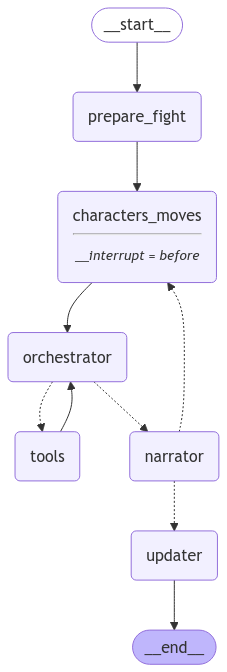

In [6]:
from IPython.display import Image

# Image(graph.get_graph().draw_png())
Image(abot.graph.get_graph().draw_mermaid_png())